In [1]:
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import glob
import pickle
import sklearn.metrics as skmetrics

In [5]:

from scipy.special import j0 as bessel_j0

def transform_to_spatial_freq(r,R_r,k,dr=dr):

    res = 2 * np.pi * np.sum(r * bessel_j0(k * r) * R_r * dr)/1000/1000
    return res

In [6]:
def calculate_real_frequencies_from_prepends(freq_prepends):
    """
    calculate real spatial frequencies k = 2pi/L from frequencies prepends
    """
    return 2*np.pi*np.array([x/160. for x in [float(x) for x in freq_prepends]])

In [7]:

freqs=['01', '02', '04', '06', '10', '12', '14', '22', '26', '40', '44']
ks = calculate_real_frequencies_from_prepends(freqs)

distances = np.array([0.1]+[0.2]*98)

In [8]:
def get_Rk(R_r,r,ks):
    R_k = []
    for k in ks:
        R_k.append(transform_to_spatial_freq(r,R_r,k))
        
    return np.array(R_k)

In [15]:
glob.glob('data/*')

['data/knn_scaler_11.pkl',
 'data/Phantom_MCML_knn.ipynb',
 'data/knn_mus_11.pkl',
 'data/modeling_results_SFDI_11_ext.pkl.zip',
 'data/knn_mua_11.pkl']

In [18]:
from zipfile import ZipFile
zf = ZipFile('data/modeling_results_SFDI_11_ext.pkl.zip', 'r')
zf.extractall('data')
zf.close()


In [20]:
df = pd.read_pickle('data/modeling_results_SFDI_11_ext.pkl')

Text(0, 0.5, 'Коэффициент отражения')

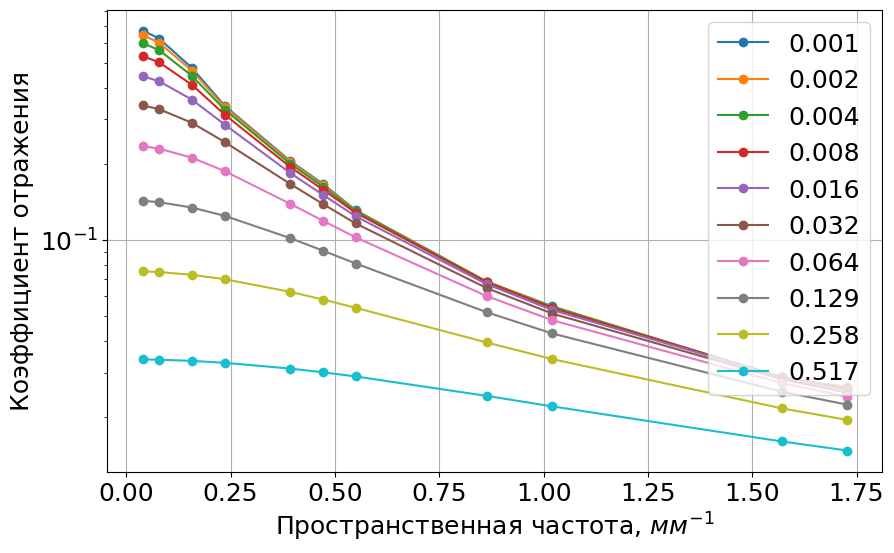

In [21]:
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,6))

for i in range(1,20_000,2000):
    plt.plot(ks[:],df.R_k.iloc[i],'o-',
             label=f'{np.round(np.float64(df.iloc[i].mua),3)}')
    plt.yscale('log')
plt.legend()
plt.grid()
plt.xlabel('Пространственная частота, $мм^{-1}$')
plt.ylabel('Коэффициент отражения')

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [23]:
df_train, df_test = train_test_split(df, test_size=0.2)
X_train = df_train.R_k.apply(lambda x: x[::]).values
y_train = np.array(df_train[['mua']].values).astype(float)
X_train = np.array(list(X_train))


X_test = df_test.R_k.apply(lambda x: x[::]).values
y_test = np.array(df_test[['mua']].values).astype(float)
X_test = np.array(list(X_test))


In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(float)
X_test = scaler.transform(X_test).astype(float)

In [25]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor()
from sklearn.model_selection import GridSearchCV
k_range = list(range(2, 8))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(neigh,
                    param_grid, cv=4, scoring='neg_mean_squared_error', return_train_score=True,verbose=3)
  
# fitting the model for grid search
grid_search_knn=grid.fit(X_train, y_train)


Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV 1/4] END n_neighbors=2;, score=(train=-0.000, test=-0.000) total time=   0.0s
[CV 2/4] END n_neighbors=2;, score=(train=-0.000, test=-0.000) total time=   0.0s
[CV 3/4] END n_neighbors=2;, score=(train=-0.000, test=-0.000) total time=   0.0s
[CV 4/4] END n_neighbors=2;, score=(train=-0.000, test=-0.000) total time=   0.0s
[CV 1/4] END n_neighbors=3;, score=(train=-0.000, test=-0.000) total time=   0.0s
[CV 2/4] END n_neighbors=3;, score=(train=-0.000, test=-0.000) total time=   0.0s
[CV 3/4] END n_neighbors=3;, score=(train=-0.000, test=-0.000) total time=   0.0s
[CV 4/4] END n_neighbors=3;, score=(train=-0.000, test=-0.000) total time=   0.0s
[CV 1/4] END n_neighbors=4;, score=(train=-0.000, test=-0.000) total time=   0.0s
[CV 2/4] END n_neighbors=4;, score=(train=-0.000, test=-0.000) total time=   0.0s
[CV 3/4] END n_neighbors=4;, score=(train=-0.000, test=-0.000) total time=   0.0s
[CV 4/4] END n_neighbors=4;, score=(tr

In [26]:
regressor_mua = grid_search_knn.best_estimator_
regressor_mua.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.0081945985831856


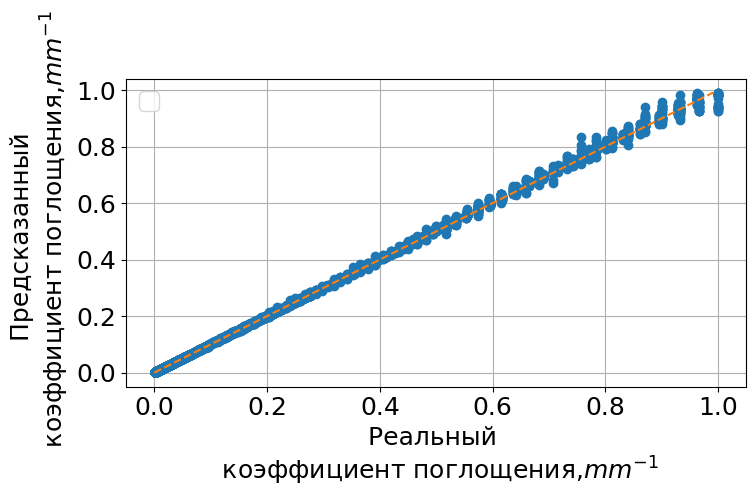

In [27]:
plt.figure(figsize=(8,4))
list1 = regressor_mua.predict(X_test).reshape(-1,1)
list1=np.array(list1,dtype=float)
list2=y_test
list2=np.array(list2,dtype=float)
print((abs((np.array(list1)-np.array(list2)))/np.array(list1)).mean())

plt.plot(list2,list1,'o')
x=np.linspace(0,max(list1),100)
plt.plot(x,x,'--')
plt.xlabel('Реальный \n коэффициент поглощения,$mm^{-1}$')
plt.ylabel('Предсказанный \n коэффициент поглощения,$mm^{-1}$')
plt.legend()
plt.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


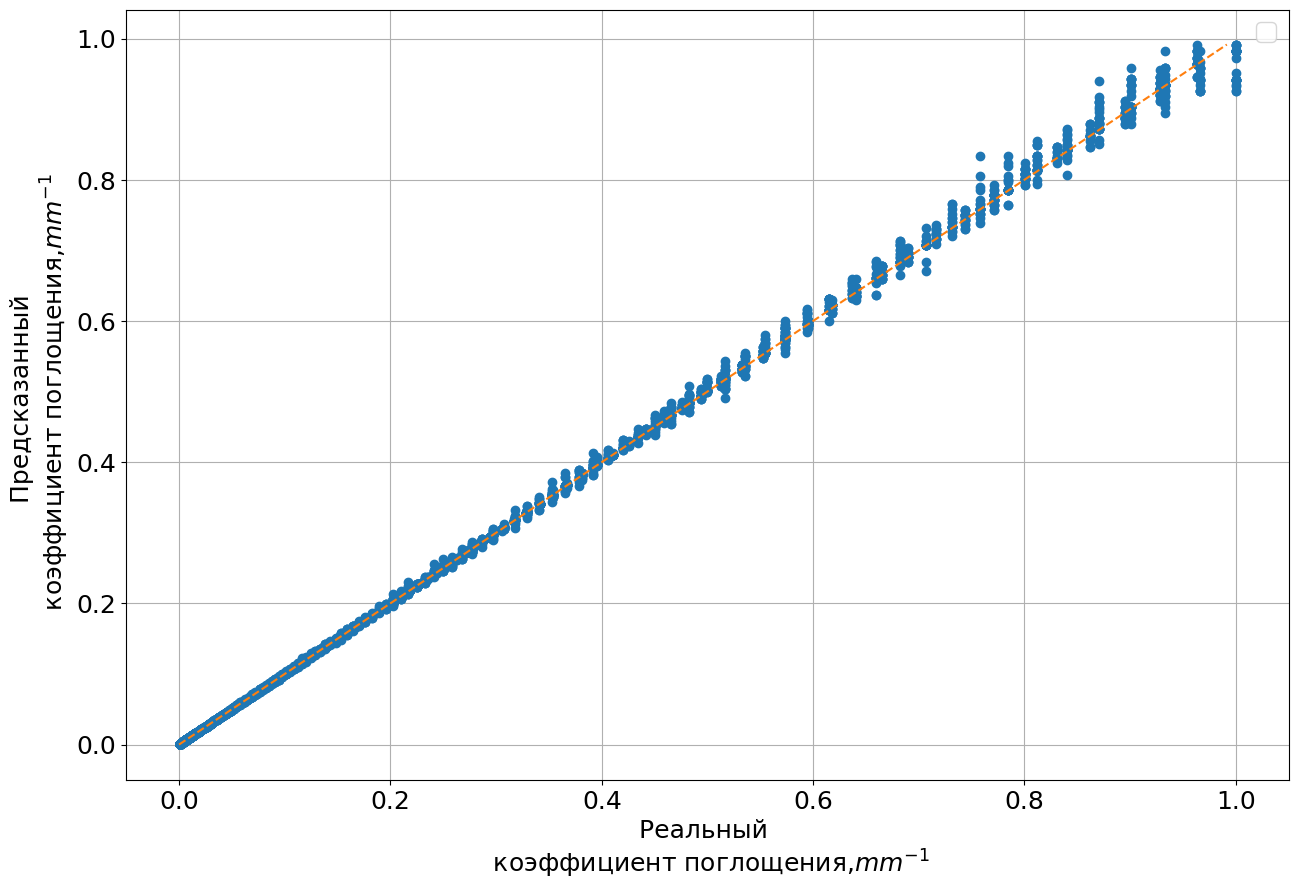

In [28]:
plt.figure(figsize=(15,10))
list1 = regressor_mua.predict(X_test).reshape(-1,1)
list1 = np.array(list1, dtype=float)
list2 = y_test
list2 = np.array(list2, dtype=float)


plt.plot(list2,list1,'o')
x = np.linspace(0,max(list1),100)
plt.plot(x,x,'--')
plt.xlabel('Реальный \n коэффициент поглощения,$mm^{-1}$')
plt.ylabel('Предсказанный \n коэффициент поглощения,$mm^{-1}$')
plt.legend()
plt.grid()

In [31]:
from torchvision import datasets
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader

In [33]:


class Dataset_mua(Dataset):
 
    def __init__(self,X,y,train=True):

        

        self.x_train = torch.tensor(X.astype(np.float32))
        self.y_train = torch.tensor(y.astype(np.float32))
    def __len__(self):
        return len(self.y_train)
   
    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]

In [1]:
train = Dataset_mua(X_train, y_train)
test = Dataset_mua(X_test, y_test)
train_loader = DataLoader(train, batch_size=512, shuffle=True)
test_loader = DataLoader(test, batch_size=5120, shuffle=False)

NameError: name 'Dataset_mua' is not defined

In [43]:
import torch
import torch.nn.functional as F
from torch import nn
in_size=11
# define the network class
n=11

class FC(nn.Module):
    def __init__(self):
        # call constructor from superclass
        super().__init__()
        self.relu = nn.ReLU()
        # define network layers
        self.fc1 = nn.Sequential(nn.Linear(in_size,n),nn.BatchNorm1d(n))
        self.fc2 = nn.Sequential(nn.Linear(n, n-2),nn.BatchNorm1d(n-2))
        self.fc3 = nn.Sequential(nn.Linear(n-2, n-4),nn.BatchNorm1d(n-4))
        self.fc4 = nn.Sequential(nn.Linear(n-4, n-6),nn.BatchNorm1d(n-6))
        self.fc5 = nn.Sequential(nn.Linear(n-6, n-8),nn.BatchNorm1d(n-8))
        self.fc6 = nn.Linear(n-8, 1)
        
    def forward(self, x):
        # define forward pass
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)

        return x
    

# instantiate the model
model = FC()


In [46]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


In [47]:
for epoch in range(200):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        
    if epoch%10==0:
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss :.3f}')
    scheduler.step(running_loss)
    running_loss = 0.0

print('Finished Training')

[1,    55] loss: 9.288
[11,    55] loss: 0.080
[21,    55] loss: 0.058
[31,    55] loss: 0.057
[41,    55] loss: 0.033
[51,    55] loss: 0.024
[61,    55] loss: 0.028
[71,    55] loss: 0.023
[81,    55] loss: 0.026
[91,    55] loss: 0.026
[101,    55] loss: 0.023
[111,    55] loss: 0.026
[121,    55] loss: 0.023
[131,    55] loss: 0.021
[141,    55] loss: 0.019
[151,    55] loss: 0.028
[161,    55] loss: 0.024
[171,    55] loss: 0.028
[181,    55] loss: 0.022
[191,    55] loss: 0.024
Finished Training


In [41]:
inputs, muas = next(iter(test_loader))   
list1, list2 = (list(t) for t in zip(*sorted(zip(muas[:,0].numpy(), model(inputs).detach().numpy()[:,0]))))

No handles with labels found to put in legend.


0.18418257


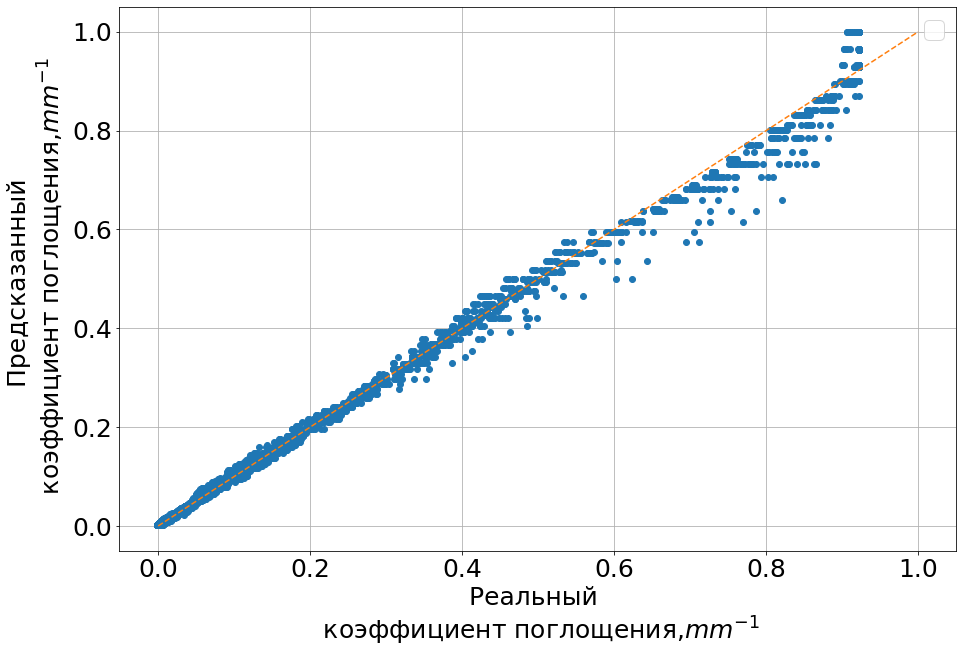

In [42]:
plt.figure(figsize=(15,10))
print((abs((np.array(list1)-np.array(list2)))/np.array(list1)).mean())

plt.plot(list2,list1,'o')
x=np.linspace(0,max(list1),100)
plt.plot(x,x,'--')
plt.xlabel('Реальный \n коэффициент поглощения,$mm^{-1}$')
plt.ylabel('Предсказанный \n коэффициент поглощения,$mm^{-1}$')
plt.legend()
plt.grid()